In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,BatchNormalization,Reshape,Conv2DTranspose,UpSampling2D
from tensorflow.keras.layers import Input , Lambda
from keras import backend as k

# Load the dataset and label it :

In [3]:
import glob
path = "/kaggle/input/rock-paper-scissors-dataset/"
# Use glob to get all PNG files in the train subdirectories
data = glob.glob("/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/paper/*.png")
data += glob.glob("/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/rock/*.png")
data += glob.glob("/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/scissors/*.png")
images = [plt.imread(img) for img in data]
print(len(images))

2520


In [ ]:
# Map for quick lookup
label_map = {'paper': 0, 'rock': 1, 'scissors': 2}

# Efficient list comprehension
Y = np.array([label_map.get(x.split('/')[-2]) for x in data])

# Shuffle the arrays consistently
images = np.array(images)
images, Y = shuffle(images, Y, random_state=0)

## Display some images:

In [2]:
def display(images,a):
        m,n = 1, int(len(images)/a)
        for i in range(0,len(images),m*n):
            fig = plt.figure(figsize=(15,8))
            for j in range(m*n):
                fig.add_subplot(m,n,j+1)
                plt.imshow(images[i+j])
                plt.axis('off')
            plt.show()

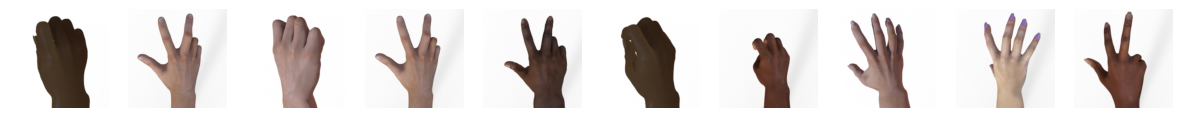

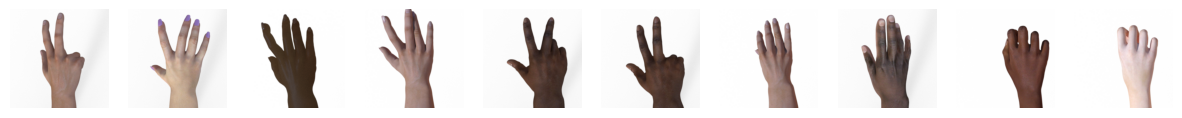

In [5]:
display(images[:20],2)

## split the data into train and test:

In [6]:
XTrain,XTest ,YTrain,YTest =train_test_split(images, Y, train_size=0.8)

# Design a simple convolutional autoencoder to reconstruct an image.

In [7]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        # Encoder:
        self.encoder = Sequential()
        self.encoder.add(Conv2D(8,(3,3),1,activation = 'relu',input_shape=(300,300,4)))
        self.encoder.add(Conv2D(16,(3,3),1,activation = 'relu'))
        self.encoder.add(MaxPooling2D())
        self.encoder.add(BatchNormalization())
        self.encoder.add(Conv2D(32,(3,3),1,activation = 'relu'))
        self.encoder.add(Conv2D(16,(3,3),1,activation = 'relu'))
        self.encoder.add(MaxPooling2D())
        self.encoder.add(Conv2D(16,(3,3),1,activation = 'relu'))
        self.encoder.add(Conv2D(8,(3,3),1,activation = 'relu'))
        self.encoder.add(MaxPooling2D())
        self.encoder.add(BatchNormalization())
        self.encoder.add(Flatten())
        self.encoder.add(Dense(100))#,activation = 'softmax'))
        # Decoder: 
        self.decoder = Sequential()
        self.decoder.add(Dense(units = 34*34*8,activation = 'relu',input_shape=(100,)))
        self.decoder.add(Reshape(target_shape = (34, 34, 8)))
        self.decoder.add(UpSampling2D((2, 2),interpolation="bilinear"))
        self.decoder.add(BatchNormalization())
        self.decoder.add(Conv2DTranspose(8,(3,3),1,activation = 'relu'))
        self.decoder.add(Conv2DTranspose(16,(3,3),1,activation = 'relu'))
        self.decoder.add(BatchNormalization())
        self.decoder.add(UpSampling2D((2,2),interpolation='bilinear'))
        self.decoder.add(Conv2DTranspose(32,(3,3),1,activation = 'relu'))
        self.decoder.add(Conv2DTranspose(16,(3,3),1,activation = 'relu'))
        self.decoder.add(UpSampling2D((2,2),interpolation='bilinear'))
        self.decoder.add(Conv2DTranspose(16,(3,3),1,activation = 'relu'))
        #self.decoder.add(Conv2DTranspose(8,(3,3),1,activation = 'relu'))
        self.decoder.add(Conv2DTranspose(4,(3,3),1,activation = 'sigmoid'))

    def call(self,x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode


In [8]:
AE = AutoEncoder()
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer =opt,loss = tf.losses.MeanSquaredError(),metrics = ['accuracy'])
AE.build((1008, 300, 300, 4))
AE.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │       939,204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │       948,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,887,264 (7.20 MB)

 Trainable params: 1,887,168 (7.20 MB)

 Non-trainable params: 96 (384.00 B)

# Train the model:

In [11]:
hist = AE.fit(XTrain,XTrain,epochs = 100, validation_split=0.3)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 337ms/step - accuracy: 0.6631 - loss: 0.0012 - val_accuracy: 0.6674 - val_loss: 0.0015
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 246ms/step - accuracy: 0.6638 - loss: 0.0012 - val_accuracy: 0.6673 - val_loss: 0.0015
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - accuracy: 0.6679 - loss: 0.0013 - val_accuracy: 0.6697 - val_loss: 0.0015
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 236ms/step - accuracy: 0.6698 - loss: 0.0012 - val_accuracy: 0.6720 - val_loss: 0.0014
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.6640 - loss: 0.0012 - val_accuracy: 0.6705 - val_loss: 0.0014
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.6699 - loss: 0.0012 - val_accuracy: 0.6719 - val_loss: 0.0014
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.6690 - loss: 0.0012 - val_accuracy: 0.6766 - val_loss: 0.0014
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 232ms/step - accuracy: 0.6735 - loss: 0.0011 - 

# Display the reconstracted images:

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


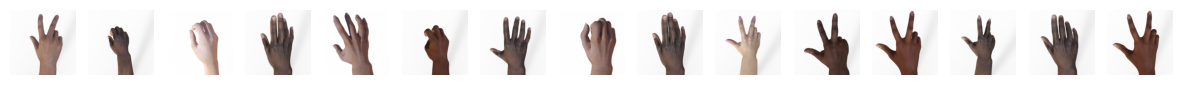

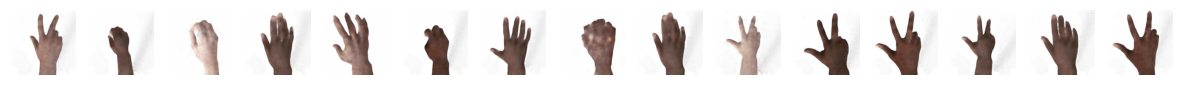

In [12]:
rec = AE.predict(XTest)
display(XTest[:15],1)
display(rec[:15],1)

# Use the latent space of the above CAE to classify the dataset using SVM.

In [13]:
def accuracy(y,pr):
    a = sum(pr==y)/ y.size
    return a

In [16]:
from sklearn import svm
vectors = AE.encoder.predict(XTrain)
SVM = svm.SVC()
SVM.fit(vectors,YTrain)

# get the latent space of AE:
Vtest = AE.encoder.predict(XTest)
pred = SVM.predict(Vtest)
accuracy(YTest,pred)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


1.0

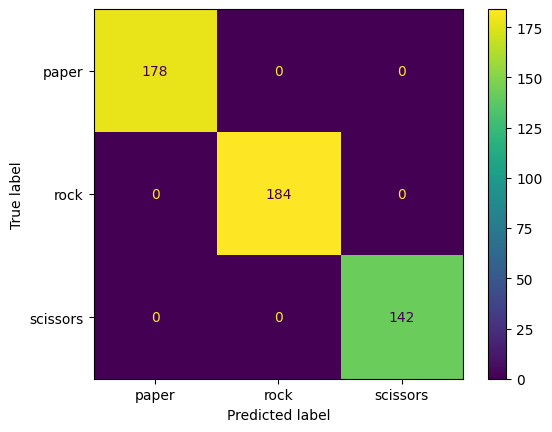

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(YTest, pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['paper', 'rock', 'scissors'])
disp.plot(cmap='viridis')